In [1]:
from pycalphad import Database, equilibrium, calculate, binplot
import pycalphad.variables as v
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
import numpy as np
import pandas as pd
% matplotlib inline

In [2]:
x_SN = np.array([0., 0.0422, 0.1104, 0.2510, 0.3815, 0.5181, 0.6265, 0.7851, 1])
sigma_SN = np.array([895.7, 858.5, 822.2, 690.3, 613.7, 565.6, 542.0, 515.2, 493.3])

R = 8.314462 # Дж/(моль∙К)
T = 1250 # K
p = 101325 # Pa

sigma_ag = 897 / 1000
sigma_sn = 496 / 1000

A_ag = 4.71 * 10**4
A_sn = 6.36 * 10**4

In [3]:
from sympy.solvers import solve
from sympy import Symbol, Eq, ln
from scipy.optimize import fsolve, brentq, fmin, minimize
from math import log

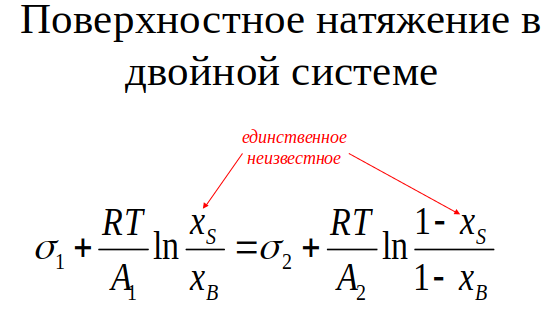

Находим x_s при котором решение ~= 0

Формула преобразована и все переменные перенесены на одну сторону

In [4]:
# Поверхностное натяжение
def surface_tension_equation(x_s, x_b):
    return sigma_ag - sigma_sn + ((R*T)/A_ag) * log((1-x_s)/(1-x_b)) - ((R*T)/A_sn) * log(x_s/x_b)

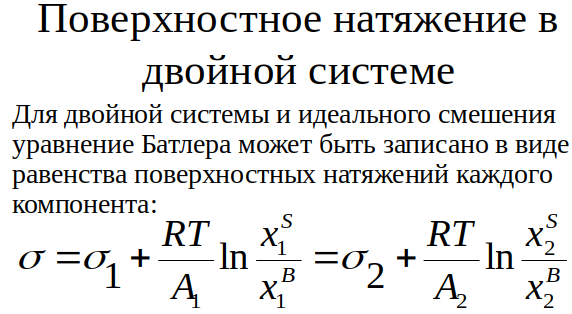

In [5]:
def surface_tension_sigma(x_s, x_b, sigma, A, T=1250):
    R = 8.314462
    return sigma + (R*T)*np.log(x_s/x_b) / A

In [6]:
# находим x_s - концентрации конмпонента на поверхности 
x_b = np.linspace(0.01, 1, 100) # define x_b in range (0, 1)
calc_x_s = []
for x_bi in x_b:
    x_s_i = None
    try:
        x_s_i = brentq(surface_tension_equation, 0.001, 0.9999, args = (x_bi))
    except Exception as e:
        pass
    if x_s_i is not None:
        calc_x_s.append(x_s_i)

calc_x_s = np.array(calc_x_s)
x_b = x_b[:calc_x_s.shape[0]]

/home/vadim/miniconda3/envs/thermo/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# Находим поверхностное натяжение для x_s, x_b
calc_sigma = surface_tension_sigma(calc_x_s, x_b, sigma=sigma_sn, A=A_sn)

## Задача 4.1
- рассчитать поверхностное натяжение как функцию x(Sn) в системе Ag-Sn при T=1250 K и p=101325 Pa
- Построить график поверхностного натяжения и сравнить с экспериментальными данными

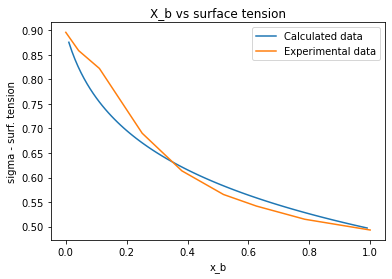

In [8]:
plt.plot(x_b, calc_sigma, label='Calculated data')
plt.plot(x_SN, sigma_SN/1000, label='Experimental data')
plt.xlabel('x_b')
plt.ylabel('sigma - surf. tension')
plt.title('X_b vs surface tension')
plt.legend()
plt.show()

## Задача 4.2
- Записать полином Редлиха-Кистера второго порядка (n = 2) для бинарной системы A-B в общем виде
- Найти и записать парциальные энергии Гиббса компонентов A и B
- Используя решение Задачи 3.3, получить выражение для избыточной энергии Гиббса в виде полинома Редлиха-Кистера в зависимости от x(Si) в системе Fe-Si при T=1823 K и p=101325 Pa
- Получить уравнения для парциальных мольных избыточных энергий Гиббса компонентов Fe и Si в зависимости от x(Si) при указанных условиях

- 4.2.1 Записать полином Редлиха-Кистера второго порядка (n = 2) для бинарной системы A-B в общем виде

![](4.2.1.jpg)

- 4.2.2. Найти и записать парциальные энергии Гиббса компонентов A и B

![](4.2.2.jpg)

In [9]:
db_FeSi = Database('databases/lab3/FeSi-17Cui.tdb')

In [10]:
FeSi_phases = list(db_FeSi.phases.keys())
T_FeSi = 1823

In [11]:
# выбрать фазу Liquid т.к. с остальными фазами происходит зависание
eq_FeSi = equilibrium(db_FeSi, FeSi_phases, ['LIQUID'], {v.X('SI'): (0, 1, 0.1),
                                                          v.P: 101325,
                                                          v.T: T_FeSi,
                                                          v.N: 1}, 
                      output='GM_MIX')

In [12]:
x_si = eq_FeSi.X_SI.values
FeSi_GM_MIX = eq_FeSi.GM_MIX.values.squeeze()

# Избыточная энергия Гиббса
G_ideal = R*1823*(x_si*np.log(x_si) + (1-x_si)*np.log(1-x_si))
G_ex = FeSi_GM_MIX - G_ideal

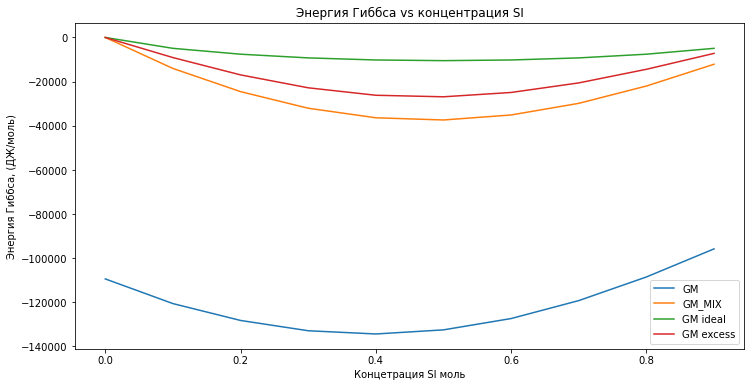

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(x_si, eq_FeSi.GM.values.squeeze(), label='GM')
plt.plot(x_si, eq_FeSi.GM_MIX.values.squeeze(), label='GM_MIX')
plt.plot(x_si, G_ideal, label='GM ideal')
plt.plot(x_si, G_ex, label='GM excess')

plt.xlabel('Концетрация SI моль')
plt.ylabel('Энергия Гиббса, (ДЖ/моль)')
plt.title('Энергия Гиббса vs концентрация SI')
plt.legend()
plt.show()

- 4.2.3 Используя решение Задачи 3.3, получить выражение для избыточной энергии Гиббса в виде полинома Редлиха-Кистера в зависимости от x(Si) в системе Fe-Si при T=1823 K и p=101325 Pa

In [14]:
L0 = lambda x: x - x**2
L1 = lambda x: x - 3 * x ** 2 + 2 * x ** 3
L2 = lambda x: x - 5 * x ** 2 + 8 * x ** 3 - 4 * x ** 4

L_matrix = np.zeros((3, 3))
Gex_vector = np.zeros(3)

In [15]:
# Находим избыточную энергию для X_si(i) - x_si
L_list = [L0, L1, L2]

for i in range(3):
    for j in range(3):
        L_matrix[i][j] = L_list[j](x_si[i+1]) # +1 т.к. x_si[0] ~= 0
    Gex_vector[i] = FeSi_GM_MIX[i+1] - G_ideal[i+1]

In [16]:
L_calc = np.linalg.solve(L_matrix, Gex_vector)
print('\n'.join([f'L{i} = {val:.3f}' for i, val in enumerate(L_calc)]))

L0 = -107546.606
L1 = -13209.205
L2 = 26297.520


$$\text{Подставляем найденные значения } L_{i} \text{ в } G^{ex}(T,X) = > $$
$$G^{ex}(T,X) = X(1-X)(-107546.6-13209.2*(1-2X)+26297.5*(1-2X)^2)$$

- 4.2.4 Получить уравнения для парциальных мольных избыточных энергий Гиббса компонентов Fe и Si в зависимости от x(Si) при указанных условиях

![Парциальные энергии](4.2.4.jpg)

## Задача 4.3
- Вычислить идеальное поверхностное натяжение как функцию x(Si) в системе Fe-Si при T=1823 K и p=101325 Pa
    - sigma_Fe = 1729 mN/m; sigma_Si = 759 mN/m
    - AFe = 3.68·10^4 m2/mol; ASi = 4.66·10^4 m2/mol
- Вычислить неидеальное поверхностное натяжение по модели Танаки (b = 0.83)
- Построить графики идеального и неидеального поверхностного натяжения и сравнить с экспериментальными данными

In [17]:
sigma_Fe = 1729 / 1000
sigma_Si = 759 / 1000

A_Fe = 3.68 * 10**4
A_Si = 4.66 * 10**4

T2 = 1823
Tanaki_beta = 0.83

In [18]:
# Поверхностное натяжение Fe-Si
def surface_tension_equation_FeSi(x_s, x_b):
    return sigma_Fe - sigma_Si + ((R*T2)/A_Fe) * log((1-x_s)/(1-x_b)) - ((R*T2)/A_Si) * log(x_s/x_b)

In [19]:
# находим x_s - концентрации конмпонента на поверхности для Fe-Si
FeSi_x_b = np.linspace(0.01, 1, 100) # define x_b in range (0, 1)
FeSi_x_s = []
for x_bi in FeSi_x_b:
    x_s_i = None
    try:
        x_s_i = brentq(surface_tension_equation_FeSi, 0.001, 0.9999, args = (x_bi))
    except Exception as e:
        pass
    if x_s_i is not None:
        FeSi_x_s.append(x_s_i)

FeSi_x_s = np.array(FeSi_x_s)
FeSi_x_b = FeSi_x_b[:FeSi_x_s.shape[0]]

/home/vadim/miniconda3/envs/thermo/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
# Находим поверхностное натяжение (sigma) для Si
calc_sigma_ideal = surface_tension_sigma(x_s=FeSi_x_s, x_b=FeSi_x_b, sigma=sigma_Si, A=A_Si, T=T2)

**Изменил расчет парциальных энергий, тут была ошибка**

In [61]:
def A_part_energy(x):
    """Парциальная энергия для A.
    Li_calc(x) - значения внутри скобок, на которое умножается Li, найденное выше
    """
    return L_calc[0]*(x**2) + \
           L_calc[1]*(3*x**2 - 4*x**3) + \
           L_calc[2]*(5*x**2 - 16*x**3 + 12*x**4)

def B_part_energy(x):
    """Парциальная энергия для B.
    Li_calc(x) - значения внутри скобок, на которое умножается Li, найденное выше
    """
    return L_calc[0]*(1 - 2*x + x**2) + \
           L_calc[1]*(1 - 6*x + 9*x**2 - 4*x**3) + \
           L_calc[2]*(1 - 10*x + 29*x**2 - 32*x**3 + 12*x**4)

In [62]:
def tanaki_equation(x_s, x_b, T):
    return sigma_Si - sigma_Fe + R * T * (np.log(x_s/x_b)/A_Si - np.log((1-x_s)/(1-x_b))/A_Fe) + \
            (Tanaki_beta * B_part_energy(x_s) - B_part_energy(x_b))/A_Si - \
            (Tanaki_beta * A_part_energy(x_s) - A_part_energy(x_b))/A_Fe

In [63]:
def tanaki(x_s, x_b, T):
    return sigma_Si + R * T * np.log(x_s/x_b)/A_Si + (Tanaki_beta * B_part_energy(x_s) - B_part_energy(x_b))/A_Si

- 4.3.1 Вычислить идеальное поверхностное натяжение как функцию x(Si)

In [66]:
# Находим x_s с помощью модели Танаки
FeSi_x_b = np.linspace(0.01, 1, 100) # define x_b in range (0, 1)
tanaki_FeSi_x_b = [] # Массив для x_b для которых получлось найти решение
tanaki_FeSi_x_s = [] # Массив найденных x_s для x_bi
for x_bi in FeSi_x_b:
    x_s_i = None
    try:
        x_s_i = brentq(tanaki_equation, 0.01, 0.9999, args = (x_bi, T2))
    except Exception as e:
        print(e)
#         break
    if x_s_i is not None:
        tanaki_FeSi_x_s.append(x_s_i)
        tanaki_FeSi_x_b.append(x_bi)

tanaki_FeSi_x_s = np.array(tanaki_FeSi_x_s)
tanaki_FeSi_x_b = np.array(tanaki_FeSi_x_b)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs
f(a) and f(b) must have different signs


/home/vadim/miniconda3/envs/thermo/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


- 4.3.2 Вычислить неидеальное поверхностное натяжение по модели Танаки (b = 0.83)

In [67]:
Tanaki_calc = tanaki(x_s=tanaki_FeSi_x_s, x_b=tanaki_FeSi_x_b, T=T2)

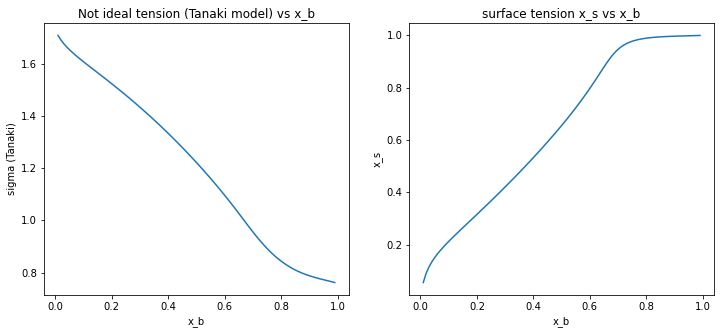

In [72]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].plot(tanaki_FeSi_x_b, Tanaki_calc)
axes[0].set_ylabel('sigma (Tanaki)')
axes[0].set_xlabel('x_b')
axes[0].set_title('Not ideal tension (Tanaki model) vs x_b')

axes[1].plot(tanaki_FeSi_x_b, tanaki_FeSi_x_s)
axes[1].set_ylabel('x_s')
axes[1].set_xlabel('x_b')
axes[1].set_title('surface tension x_s vs x_b')

plt.show()

- 4.3.3 Построить графики идеального и неидеального поверхностного натяжения и сравнить с экспериментальными данными

In [69]:
# Экспериментальные данные
ds1 = pd.DataFrame(data={'x_Si': [0.0000, 0.060, 0.128, 0.188, 0.253, 0.381, 0.493, 0.697, 0.746, 0.856],
                         'sigma': [1765.3, 1706.6, 1639.9, 1586.5, 1525.2, 1383.8, 1173.0, 884.8, 828.8, 770.1]})
ds2 = pd.DataFrame(data={'x_Si': [0.0000, 0.008, 0.091, 0.180, 0.331, 0.454, 0.480, 0.501, 0.535, 0.561, 0.663, 0.744, 0.822, 0.914, 1.000],
                         'sigma': [1728.0, 1682.6, 1613.2, 1551.9, 1335.7, 1223.7, 1210.3, 1122.3, 1114.3, 983.5, 895.5, 772.7, 746.1, 775.4, 759.4]})
ds3 = pd.DataFrame(data={'x_Si': [0.042, 0.102, 0.175, 0.321, 0.493, 0.660, 0.822],
                         'sigma': [1682.6, 1634.6, 1573.2, 1423.8, 1143.6, 871.5, 778.1]})

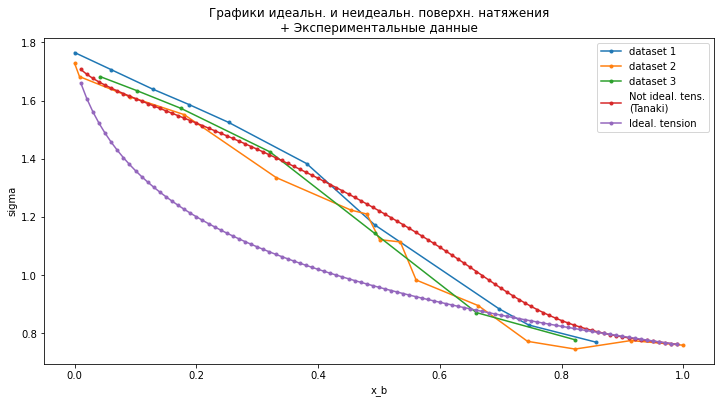

In [73]:
plt.figure(figsize=(12, 6))
plt.plot(ds1['x_Si'], ds1['sigma']/1000, label='dataset 1', marker='.')
plt.plot(ds2['x_Si'], ds2['sigma']/1000, label='dataset 2', marker='.')
plt.plot(ds3['x_Si'], ds3['sigma']/1000, label='dataset 3', marker='.')
plt.plot(tanaki_FeSi_x_b, Tanaki_calc, label='Not ideal. tens.\n(Tanaki)', marker='.')
plt.plot(x_b, calc_sigma_ideal, label='Ideal. tension', marker='.')

plt.ylabel('sigma')
plt.xlabel('x_b')
plt.legend()
plt.title('Графики идеальн. и неидеальн. поверхн. натяжения\n+ Экспериментальные данные')
plt.show()